In [1]:
# module
import os
import matplotlib.pylab as pl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import datetime
import cv2
import numpy as np
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import dataset_invariance
import index_qualitative
from torch.autograd import Variable
import csv
import time
import tqdm
import torch.nn.functional as F

# Scene colormap 
colors = [(0, 0, 0), (0.87, 0.87, 0.87), (0.54, 0.54, 0.54), (0.49, 0.33, 0.16), (0.29, 0.57, 0.25)]
cmap_name = 'scene_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=5)

In [2]:
# function
def draw_track(past, future, pred=None, video_id='', vec_id='', index_tracklet=0):

    fig = plt.figure()
    plt.plot(past[:, 0], past[:, 1], c='blue', linewidth=1, marker='o', markersize=1)
    plt.plot(future[:, 0], future[:, 1], c='green', linewidth=1, marker='o', markersize=1)
    if pred is not None:
        plt.plot(pred[:, 0], pred[:, 1], c='red', linewidth=1, marker='o', markersize=1)
    plt.axis('equal')
    plt.title(video_id + '_' + vec_id + '_' + str(index_tracklet).zfill(3))
    plt.show()
    plt.close(fig)

def draw_track_with_MANTRA(past, future, scene, preds=None, video_id='', vec_id='', index_tracklet=0):

    fig = plt.figure()
    plt.plot(past[:, 0], past[:, 1], c='blue', linewidth=1, marker='o', markersize=1)
    plt.plot(future[:, 0], future[:, 1], c='green', linewidth=1, marker='o', markersize=1)
    for p in range(preds.shape[0]):
        plt.plot(preds[p, :, 0], preds[p, :, 1], c='red', linewidth=1, marker='o', markersize=1)
    plt.axis('equal')
    plt.title(video_id + '_' + vec_id + '_' + str(index_tracklet).zfill(3))
    plt.show()
    plt.close(fig)

In [41]:
    def draw_track(past, future, scene_track, pred=None, angle=0, video_id='', vec_id='', index_tracklet=0,
                    horizon_dist=None):
        """
        Plot past and future trajectory and save it to test folder.
        :param past: the observed trajectory
        :param future: ground truth future trajectory
        :param pred: predicted future trajectory
        :param angle: rotation angle to plot the trajectory in the original direction
        :param video_id: video index of the trajectory
        :param vec_id: vehicle type of the trajectory
        :param pred: predicted future trajectory
        :param: the observed scene where is the trajectory
        :param index_tracklet: index of the trajectory in the dataset (default 0)
        :param num_epoch: current epoch (default 0)
        :return: None
        """

        colors = [(0, 0, 0), (0.87, 0.87, 0.87), (0.54, 0.54, 0.54), (0.49, 0.33, 0.16), (0.29, 0.57, 0.25)]
        cmap_name = 'scene_cmap'
        cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=5)
        fig = plt.figure()
        plt.imshow(scene_track, cmap=cm)
        colors = pl.cm.Reds(np.linspace(1, 0.3, pred.shape[0]))

        matRot_track = cv2.getRotationMatrix2D((0, 0), -angle, 1)
        past = cv2.transform(past.numpy().reshape(-1, 1, 2), matRot_track).squeeze()
        future = cv2.transform(future.numpy().reshape(-1, 1, 2), matRot_track).squeeze()
        story_scene = past * 2 + dim_clip
        future_scene = future * 2 + dim_clip
        plt.plot(story_scene[:, 0], story_scene[:, 1], c='blue', linewidth=1, marker='o', markersize=1)
        if pred is not None:
            for i_p in reversed(range(pred.shape[0])):
                pred_i = cv2.transform(pred[i_p].numpy().reshape(-1, 1, 2), matRot_track).squeeze()
                pred_scene = pred_i * 2 + dim_clip
                plt.plot(pred_scene[:, 0], pred_scene[:, 1], color=colors[i_p], linewidth=0.5, marker='o', markersize=0.5)
        plt.plot(future_scene[:, 0], future_scene[:, 1], c='green', linewidth=1, marker='o', markersize=1)
        plt.title('FDE 1s: ' + str(horizon_dist[0]) + ' FDE 2s: ' + str(horizon_dist[1]) + ' FDE 3s: ' +
                  str(horizon_dist[2]) + ' FDE 4s: ' + str(horizon_dist[3]))
        plt.axis('equal')
        plt.show()
        plt.close(fig)

In [ ]:
# Parameters
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
batch_size = 256
past_len = 20
future_len = 40
dim_embedding_key = 48
num_prediction = 5
dim_clip = 180

# Model
mem_n2n = torch.load('pretrained_models/MANTRA/model_MANTRA',  map_location=torch.device('cpu')).eval()

In [ ]:
# Dataset
tracks = json.load(open('kitti_dataset.json'))
print('creating dataset...')
data_train = dataset_invariance.TrackDataset(tracks, len_past=past_len, len_future=future_len,
                                             train=True, dim_clip=dim_clip)
data_test = dataset_invariance.TrackDataset(tracks, len_past=past_len, len_future=future_len,
                                     train=False, dim_clip=dim_clip)
train_loader = DataLoader(data_train, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, num_workers=1, shuffle=False)
print('dataset created')

# loader iterator (test)
dataiter_test = iter(test_loader)

In [34]:
# iteration (test)
(index, past, future, presents, angle_presents, videos, vehicles, number_vec, scene, scene_one_hot) = dataiter_test.next()

# AUTOENCODER AND ABLATION STUDY (IMPORTANTE OF PAST)

In [ ]:
# Model Inference
# if ablation_study is None, the inference is default.
# if 'zeros', encoding of past is all zeros.
# if 'rand', encoding of past is random numbers (standard normal distribution, mean 0, variance 1).
# if 'different', encoding of all pasts (of batch) is the encoding of 'j_ablation' past.
ablation_study = None
j_ablation = 802

with torch.no_grad():
    dim_batch = past.size()[0]
    zero_padding = torch.zeros(1, dim_batch, mem_n2n.dim_embedding_key * 2)
    reconstruction = torch.Tensor()
    present = past[:, -1, :2].unsqueeze(1)

    # temporal encoding for past
    past_t = torch.transpose(past, 1, 2)
    past_embed = mem_n2n.relu(mem_n2n.conv_past(past_t))
    past_embed = torch.transpose(past_embed, 1, 2)

    # temporal encoding for future
    future_t = torch.transpose(future, 1, 2)
    future_embed = mem_n2n.relu(mem_n2n.conv_fut(future_t))
    future_embed = torch.transpose(future_embed, 1, 2)

    # sequence encoding
    output_past, state_past = mem_n2n.encoder_past(past_embed)
    output_fut, state_fut = mem_n2n.encoder_fut(future_embed)

    if ablation_study is not None:
        if ablation_study is 'zeros':
            state_past = torch.zeros([1, dim_batch, 48])
        elif ablation_study is 'rand':
            state_past = torch.randn([1, dim_batch, 48])
        elif ablation_study is 'different':
            state_past = state_past[:,j_ablation].unsqueeze(0).repeat(1, dim_batch,1)

    # concatenate
    state_conc = torch.cat((state_past, state_fut), 2)
    input_fut = state_conc
    state_fut = zero_padding
    for i_pred in range(mem_n2n.future_len):
        output_decoder, state_fut = mem_n2n.decoder(input_fut, state_fut)
        displacement_next = mem_n2n.FC_output(output_decoder)
        coords_next = present + displacement_next.squeeze(0).unsqueeze(1)
        reconstruction = torch.cat((reconstruction, coords_next), 1)
        present = coords_next
        input_fut = zero_padding
    reconstruction = reconstruction.numpy()

In [ ]:
t = 0
draw_track(past[t], future[t], reconstruction[t], video_id=videos[t], vec_id=vehicles[t] + number_vec[t], index_tracklet=index[t].item() )

# PREDICTIONS FROM MEMORY

In [35]:
# MANTRA INFERENCE

scene_mantra = scene_one_hot.clone()
with torch.no_grad():
    dim_batch = past.size()[0]
    zero_padding = torch.zeros(1, dim_batch * num_prediction, mem_n2n.dim_embedding_key * 2)
    prediction_mantra = torch.Tensor()
    present = past[:, -1].unsqueeze(1)

    # past temporal encoding
    past_t = torch.transpose(past, 1, 2)
    story_embed = mem_n2n.relu(mem_n2n.conv_past(past_t))
    story_embed = torch.transpose(story_embed, 1, 2)
    output_past, state_past = mem_n2n.encoder_past(story_embed)

    # Cosine similarity and memory read
    past_normalized = F.normalize(mem_n2n.memory_past, p=2, dim=1)
    state_normalized = F.normalize(state_past.squeeze(dim=0), p=2, dim=1)
    weight_read = torch.matmul(past_normalized, state_normalized.transpose(0, 1)).transpose(0, 1)
    index_max = torch.sort(weight_read, descending=True)[1].cpu()[:, :num_prediction]
    present = present.repeat_interleave(num_prediction, dim=0)
    state_past = state_past.repeat_interleave(num_prediction, dim=1)
    ind = index_max.flatten()

    info_future = mem_n2n.memory_fut[ind]
    info_total = torch.cat((state_past, info_future.unsqueeze(0)), 2)
    input_dec = info_total
    state_dec = zero_padding
    for i in range(future_len):
        output_decoder, state_dec = mem_n2n.decoder(input_dec, state_dec)
        displacement_next = mem_n2n.FC_output(output_decoder)
        coords_next = present + displacement_next.squeeze(0).unsqueeze(1)
        prediction_mantra = torch.cat((prediction_mantra, coords_next), 1)
        present = coords_next
        input_dec = zero_padding
    
    scene_mantra = scene_mantra.permute(0, 3, 1, 2)
    scene_1 = mem_n2n.convScene_1(scene_mantra)
    scene_2 = mem_n2n.convScene_2(scene_1)
    scene_2 = scene_2.repeat_interleave(num_prediction, dim=0)

    # Iteratively refine predictions using context
    for i_refine in range(4):
        pred_map = prediction_mantra + 90
        pred_map = pred_map.unsqueeze(2)
        indices = pred_map.permute(0, 2, 1, 3)
        # rescale between -1 and 1
        indices = 2 * (indices / 180) - 1
        output = F.grid_sample(scene_2, indices, mode='nearest')
        output = output.squeeze(2).permute(0, 2, 1)

        state_rnn = state_past
        output_rnn, state_rnn = mem_n2n.RNN_scene(output, state_rnn)
        prediction_refine = mem_n2n.fc_refine(state_rnn).view(-1, future_len, 2)
        prediction_mantra = prediction_mantra + prediction_refine

    prediction_mantra = prediction_mantra.view(dim_batch, num_prediction, future_len, 2)

future_rep = future.unsqueeze(1).repeat(1, num_prediction, 1, 1)
distances = torch.norm(prediction_mantra - future_rep, dim=3)
mean_distances = torch.mean(distances, dim=2)
index_min = torch.argmin(mean_distances, dim=1)
distance_pred = distances[torch.arange(0, len(index_min)), index_min]

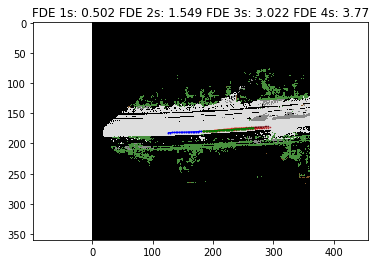

In [42]:
t = 100
horizon_dist = [round(distance_pred[t, 9].item(), 3), round(distance_pred[t, 19].item(), 3),
                round(distance_pred[t, 29].item(), 3), round(distance_pred[t, 39].item(), 3)]
draw_track(past[t], future[t], scene[t], prediction_mantra[t], angle_presents[t], videos[t], vehicles[t] + number_vec[t],
                                            index_tracklet=index[t], horizon_dist=horizon_dist)